# Naive bayes classifier

Create a Naive Bayes classifier for each handwritten digit that support discrete and continuous features

### inputs

- Training image data from [MNIST](http://yann.lecun.com/exdb/mnist/) 

### outputs

- posterior (in log scale to avoid underflow) of the ten categories (0-9) for each row in INPUT 3 
- error rate 

In [364]:
import matplotlib.pyplot as plt
from functools import reduce
from IPython.display import Latex
%config InlineBackend.figure_format = 'svg'
%config InlineBackend.figure.figsize = (8,8) 

In [54]:
def showBytesImage(byte, row = 28, col = 28):
    im = [[byte[i*28 + j] for j in range(col)] for i in range(row)]
    
    plt.imshow(im, cmap='gray')
    

class idx_file():
    def __init__(self, file):
        self.filename = file
        self.datas = []
        
        with open(self.filename, mode='rb') as f:
            magic_number = f.read(4)
            
            self.n_dim = magic_number[-1]
            
            self.n_dims = [int.from_bytes(f.read(4), byteorder='big') for _ in range(self.n_dim)]
    
            for idx in range(self.n_dims[0]):
                item = f.read(reduce(lambda x,y: x*y, (self.n_dims[1:] + [1])))
        
                self.datas.append(item)
        

In [109]:
%%time

train_images = idx_file('train-images.idx3-ubyte')

train_labels = idx_file('train-labels.idx1-ubyte')

test_images = idx_file('t10k-images.idx3-ubyte')

test_labels = idx_file('t10k-labels.idx1-ubyte')

CPU times: user 195 ms, sys: 28 ms, total: 223 ms
Wall time: 223 ms


In [46]:
len(train_images)

60000

b'\x03'


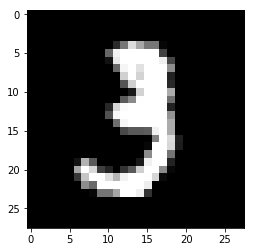

In [60]:
showBytesImage(train_images.datas[10])
print(train_labels.datas[10])

b'\x00'


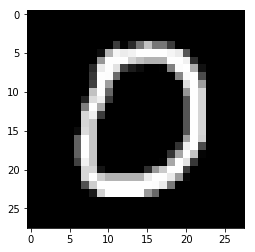

In [110]:
showBytesImage(test_images.datas[10])
print(test_labels.datas[10])

### handle feature

- discrete

map 0 ~ 255 into 0 ~ 31 bins
note : handle empty bins

- continuous

use gaussian distribution

In [87]:
%%time
for i in train_images.datas:
    tmp = [j for j in i]
    continue

CPU times: user 1.28 s, sys: 0 ns, total: 1.28 s
Wall time: 1.28 s


In [85]:
%%time
for _, i in enumerate(train_images.datas):
    tmp = [j for j in i]
    continue

CPU times: user 1.25 s, sys: 0 ns, total: 1.25 s
Wall time: 1.25 s


In [206]:
%%time
# class, pixels, bins

Pixel_P = [[[10**-6 for _ in range(32)] for _ in range(28*28)] for _ in range(10)]
Class_P = [0 for _ in range(10)]

for idx, bs in enumerate(train_images.datas):
    Class_P[train_labels.datas[idx][0]] += 1
    for i in range(len(bs)):
        Pixel_P[train_labels.datas[idx][0]][i][bs[i]>>3] += 1

CPU times: user 21.5 s, sys: 7.62 ms, total: 21.5 s
Wall time: 21.5 s


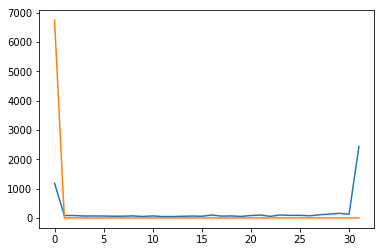

In [261]:
plt.plot(range(32), Pixel_P[0][300])
plt.plot(range(32), Pixel_P[1][87])

In [98]:
print(Pixel_P[1][300])

[6493, 44, 17, 19, 16, 7, 8, 8, 8, 11, 7, 8, 13, 8, 10, 5, 10, 7, 2, 4, 5, 2, 6, 3, 6, 4, 5, 1, 4, 5, 4, 24]


In [108]:
print(Class_P[1])
sum(Pixel_P[1][0])

6742


6774

In [271]:
import numpy as np
from math import log, sqrt, exp, pi, factorial

In [258]:
%%time

error = 0
Posterior = [[0 for _ in range(10)] for _ in range(len(test_images.datas))]
for idx, bs in enumerate(test_images.datas):
    for num in range(10):
        for i in range(len(bs)):
            Posterior[idx][num] += log(Pixel_P[num][i][bs[i]>>3])
        Posterior[idx][num] -= (len(bs)-1)*log(Class_P[num])
        #Posterior[idx][num] += log(Class_P[num])
    
    predict = np.argmax(Posterior[idx])
    answer = test_labels.datas[idx][0]
    
    if predict != answer:
        error += 1

CPU times: user 47.3 s, sys: 28.1 ms, total: 47.4 s
Wall time: 47.3 s


In [129]:
print('predict : ' + str(np.argmax(Posterior[87])) + ', answer : ' + str(test_labels.datas[87][0]))

predict : 3, answer : 3


In [259]:
print(error/len(test_images.datas))

0.1492


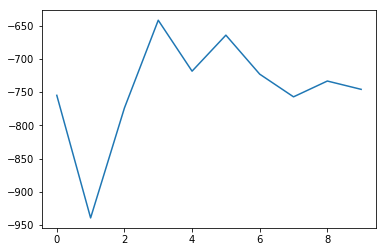

In [205]:
plt.plot(range(10), Posterior[87])

In [132]:
%%time
# class, pixels

Pixel_datas = [[[] for _ in range(28*28)] for _ in range(10)]

for idx, bs in enumerate(train_images.datas):
    for i in range(len(bs)):
        Pixel_datas[train_labels.datas[idx][0]][i].append(bs[i])

CPU times: user 20.6 s, sys: 144 ms, total: 20.8 s
Wall time: 20.8 s


In [267]:
def Gaussian(u, v):
    if v == 0:
        v = 10**-6
    return lambda x : (exp(-1*(((x - u)**2) / (2*v) ) ) / sqrt(2*pi*v))

def Normalize(a):
    n = sum(a)
    if n < 0:
        n *= -1
    return [x/n for x in a]

In [255]:
%%time

Pixel_G = [[[0, 0] for _ in range(28*28)] for _ in range(10)]

for i in range(10):
    for j in range(28*28):
        n = len(Pixel_datas[i][j])
        u = sum(Pixel_datas[i][j]) / n
        v = sum([(x - u)**2 for x in Pixel_datas[i][j]]) / n
        Pixel_G[i][j][0] = u
        Pixel_G[i][j][1] = v
        Pixel_G[i][j].append(Gaussian(u, v))

CPU times: user 8.35 s, sys: 15.8 ms, total: 8.37 s
Wall time: 8.37 s


In [173]:
print(exp(0))

1.0


[0.0014832393948383269, 0.014830193949280862, <function Gaussian.<locals>.<lambda> at 0x7f80fa77f1e0>]
0.0


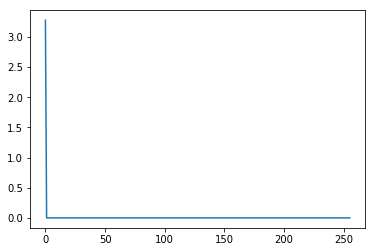

In [260]:
print(Pixel_G[1][87])
x = range(256)
plt.plot(x, [Pixel_G[1][87][2](i) for i in x])
print(Pixel_G[1][87][2](230))

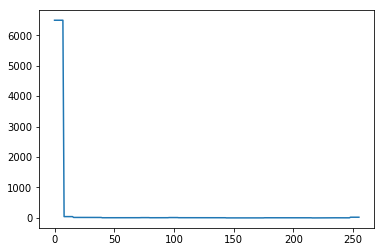

In [233]:
plt.plot(range(256), [Pixel_P[1][300][i>>3] for i in range(256)])

0.126156626101008
[-5.  -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3 -4.2 -4.1 -4.  -3.9 -3.8 -3.7
 -3.6 -3.5 -3.4 -3.3 -3.2 -3.1 -3.  -2.9 -2.8 -2.7 -2.6 -2.5 -2.4 -2.3
 -2.2 -2.1 -2.  -1.9 -1.8 -1.7 -1.6 -1.5 -1.4 -1.3 -1.2 -1.1 -1.  -0.9
 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4  0.5
  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3  1.4  1.5  1.6  1.7  1.8  1.9
  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7  2.8  2.9  3.   3.1  3.2  3.3
  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1  4.2  4.3  4.4  4.5  4.6  4.7
  4.8  4.9  5. ]


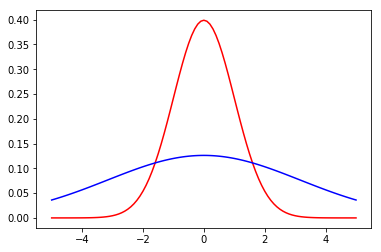

In [225]:
wow = Gaussian(0,1)
wow2 = Gaussian(0,)
x = np.linspace(-5,5,101) 
plt.plot(x, [wow(i) for i in x], 'r')
plt.plot(x, [wow2(i) for i in x], 'b')

print(wow2(0))
print(x)

In [256]:
%%time

error = 0
Posterior_G = [[0 for _ in range(10)] for _ in range(len(test_images.datas))]
for idx, bs in enumerate(test_images.datas):
    for num in range(10):
        for i in range(len(bs)):
            if Pixel_G[num][i][2](bs[i]) == 0.0:
                Posterior_G[idx][num] += log(10**-6)
                continue;
            Posterior_G[idx][num] += log(Pixel_G[num][i][2](bs[i]))
        Posterior_G[idx][num] += log(Class_P[num])
    
    predict = np.argmax(Posterior_G[idx])
    answer = test_labels.datas[idx][0]
    
    if predict != answer:
        error += 1

CPU times: user 2min 34s, sys: 3.7 ms, total: 2min 34s
Wall time: 2min 34s


In [257]:
print(error/len(test_images.datas))

0.4638


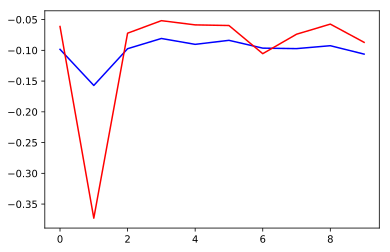

In [354]:
plt.plot(range(10), Normalize(Posterior[87]), 'b')
plt.plot(range(10), Normalize(Posterior_G[87]), 'r')

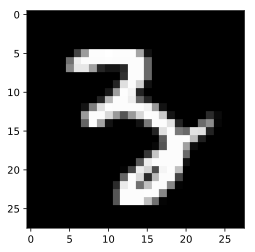

In [355]:
showBytesImage(test_images.datas[87])

# online learning

Use online learning to learn the beta distribution of the parameter p of the coin tossing trails in batch. 

### inputs

- some binary outcome

e.g.

`01010101100`

`0110101`

...

- parameter `a` , `b` for the initial beta distribution prior

### outputs

- Binomial MLE
- Prior parameter
- Posterior parameter

In [330]:
def Beta_distribution(a, b):
    c = 1/Beta(a,b)
    return lambda p : (p**(a-1)) * ((1-p)**(b-1)) * c

def Beta(a,b):
    return (Gamma(a) * Gamma(b)) / Gamma(a + b)

def Gamma(x):
    return factorial(x - 1)

def Likelihood(p, N, m):
    return (p**m)*((1-p)**(N-m))*(factorial(N)/(factorial(m)*factorial(N-m)))

def Binomial_MLE(a, b):
    return a / (a + b)

In [369]:
# load binary outcomes

online_datas = []

with open('datas.txt', 'r') as f :
    datas = f.readlines()
    for item in datas:
        item = item[:-1]
        N = len(item)
        m = 0
        for i in item:
            if i == '1':
                m += 1
        online_datas.append((N, m))

print(datas)
online_datas

['0101010111011011010101\n', '1110101\n', '110110111101\n', '11111101110111111011111111111110111111111\n']


[(22, 13), (7, 5), (12, 9), (41, 37)]

### Gamma function

$$ \Gamma (a) = \int^{ \infty }_{0} x^{a-1}e^{-x}dx  \\
= (a-1)\Gamma(a-1) \\
= (a-1)!
$$

### Beta function

$$ \beta (a,b) = \int^{1}_{0} x^{a-1}(1-x)^{b-1} d{x} \\
= \frac{\Gamma (a) \Gamma (b)}{\Gamma {a+b}}
$$

### Beta Distribution
    
$$ f_{beta}(p, a, b) = \frac{ p^{a-1}(1-p)^{b-1} }{\beta (a,b)} $$

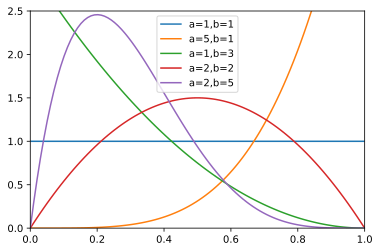

In [370]:
# test beta dis

plot_ab = [(1,1), (5,1), (1,3), (2,2), (2,5)]
plot_len = len(plot_ab)

plt.axis([0, 1, 0, 2.5])

for idx, (a, b) in enumerate(plot_ab):
    x = np.linspace(0,1,100)
    b_d = Beta_distribution(a, b)
    #plt.subplot(plot_len, 1, idx+1)
    plt.plot(x, [b_d(i) for i in x], label="a={},b={}".format(a,b))

plt.legend()
plt.show()

### Binomial Likelihood

$$ L = \prod_{i} (\begin{array}{clr} N_i \\ m_i \end{array})  p^{m_i}(1-p)^{N_i - m_i} $$

### Binomial MLE

use log and differential and get

$$ p = \frac{\sum_{i} m_i}{\sum_{i} N_i} $$


Prior(a,b) : (0,0)
MLE : 0.5909090909090909, Prior(a,b) : (0,0), Posterior(a,b) : (13,9)
MLE : 0.6206896551724138, Prior(a,b) : (13,9), Posterior(a,b) : (18,11)
MLE : 0.6585365853658537, Prior(a,b) : (18,11), Posterior(a,b) : (27,14)
MLE : 0.7804878048780488, Prior(a,b) : (27,14), Posterior(a,b) : (64,18)


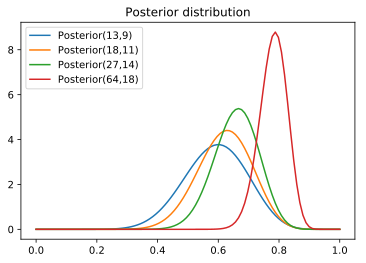

In [371]:
# beta distribution initial parameter

beta_a = 0
beta_b = 0

print("Prior(a,b) : ({},{})".format(beta_a, beta_b))
for idx, (N,m) in enumerate(online_datas):
    prior_a = beta_a
    prior_b = beta_b
    beta_a += m
    beta_b += N-m
    print("MLE : {}, Prior(a,b) : ({},{}), Posterior(a,b) : ({},{})".format(beta_a/(beta_a + beta_b), prior_a, prior_b, beta_a, beta_b))
    
    #plt.subplot(len(online_datas)*2, 1, idx*2+1)
    x = np.linspace(0,1,100)
    b_d = Beta_distribution(beta_a, beta_b)
    plt.plot(x, [b_d(i) for i in x], label="Posterior({},{})".format(beta_a, beta_b))

plt.title("Posterior distribution")
plt.legend()
plt.show()